In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

In [8]:
# Setting time resolution
d_t = 0.01

# Setting spatial limits for simulation
z_min = 0.0
z_max = 2.0

# Setting time limits for simulation
t_min = 0
t_max = 5

# Constructing a uniform grid in z
d_z = 0.01
z = np.arange(z_min, z_max, d_z)
z_0_ctr = np.arange(z_min-1, z_max-1, d_z)
dz = np.diff(z, prepend=d_z)

# Fixing a constant h
h = 0.1*np.ones_like(z)

# Setting uniformly spaced time intervals
t = np.arange(t_min, t_max, d_t)
dt = np.diff(t)

# Label according to IC/BCs
ic_count = 3

# BC type setting ('D' for Dirichlet, 'N' for Neumann)
bc_type = 'D'

In [9]:
# Setting constants for omega and alpha effects
omega = np.zeros(len(z))
alpha = np.zeros(len(z))

# Setting null velocity
V_r = np.zeros(len(z))
V_phi = np.zeros(len(z))
V_z = np.zeros(len(z))

# Diffusivity values
eta_m = 0.02            # microscopic diffusivity
eta_t = 0.5             # kinetic diffusivity
eta = eta_m + eta_t     # total diffusivity

In [10]:
# Setting initial conditions for slab approximation

if ic_count == 1:
    #IC1
    B_r = np.sin(z*1.575)
    B_phi = - np.sin(z*1.575)
elif ic_count == 2:
    #IC2
    B_r = np.sin(2*1.575*z)
    B_phi = - np.sin(2*1.575*z)
elif ic_count == 3:
    #IC3
    B_r = np.sin(0.4*np.sin(np.pi*8*(z)/(z_max-dz[-1])) + np.pi*(z)/(z_max-dz[-1]))
    B_phi = - np.sin(0.4*np.sin(np.pi*6*(z)/(z_max-dz[-1])) + np.pi*(z)/(z_max-dz[-1]))
elif ic_count == 4:
    #IC_P
    B_r = -z**2 + 1
    B_phi = z**2 - 1

In [11]:
# Full Eqn, Together

# Full Eqn in Br
def Eqn_Br(B_r, B_phi, dz=dz, eta=eta, bc_type=bc_type):
    k = []

    if bc_type == 'D':
        # Dirchlet Boundary condition at r[0]
        k.append(0)
    else:
        # Neumann boundary condition at r[0]
        k.append((B_r[1] - B_r[0]) / dz[0])
    
    for i in range(1, len(z)-1):
        k_i = d_t*(
                (  V_r[i]/(2*dz[i])         +   eta/(dz[i]**2)   - eta/(2*z[i]*dz[i])    )*B_r[i-1] +
                (  -V_r[i]/z[i] + V_z[i]/(4*h[i]) - eta/(z[i]**2) - (2*eta)/(dz[i]**2) 
                                            - (eta*np.pi**2)/(4*h[i]**2)                 )*B_r[i] +
                (  -V_r[i]/(2*dz[i])        +   eta/(dz[i]**2)   + eta/(2*z[i]*dz[i])    )*B_r[i+1] +

                ((2*alpha[i])/(np.pi*h[i]) )*B_phi[i] 
            )
        k.append(k_i)

    if bc_type == 'D':
        # Dirchlet Boundary condition at r[-1]
        k.append(0)
    else:
        # Neumann boundary condition at r[-1]
        k.append((B_r[-1] - B_r[-2]) / dz[-1])

    return np.array(k)

# Full Eqn in Bphi
def Eqn_Bphi(B_r, B_phi, dz=dz, eta=eta):
    k = []

    if bc_type == 'D':
        # Dirchlet Boundary condition at r[0]
        k.append(0)
    else:
        # Neumann boundary condition at r[0]
        k.append((B_phi[1] - B_phi[0]) / dz[0])

    for i in range(1, len(z)-1):
        k_i = d_t*(
                (V_r[i]/(2*dz[i])           + eta/(dz[i]**2) - eta/(2*z[i]*dz[i])       )*B_phi[i-1] +
                ((V_r[i-1] - V_r[i+1])/(2*dz[i]) - V_z[i]/(4*h[i]) - (2*eta)/(dz[i]**2) 
                                            - eta/(z[i]**2) - (eta*np.pi**2)/(4*h[i]**2))*B_phi[i] +
                (-V_r[i]/(2*dz[i])          + eta/(dz[i]**2) + eta/(2*z[i]*dz[i])       )*B_phi[i+1] +

                ( -z[i]*(omega[i+1] - omega[i-1])/(2*dz[i])   + (2*alpha[i])/(np.pi*h[i])  )*B_r[i]
            )                                                 ###### alpha^2 term ######
        k.append(k_i)

    if bc_type == 'D':
        # Dirchlet Boundary condition at r[-1]
        k.append(0)
    else:
        # Neumann boundary condition at r[-1]
        k.append((B_phi[-1] - B_phi[-2]) / dz[-1])
    return np.array(k)

# Runge Kutta Step
def rk4(B_r, B_phi, dt, eta=eta):
    k1_r = dt * Eqn_Br(B_r, B_phi)
    k1_phi = dt * Eqn_Bphi(B_r, B_phi)

    k2_r = dt * Eqn_Br(B_r + 0.5 * k1_r, B_phi + 0.5 * k1_phi)
    k2_phi = dt * Eqn_Bphi(B_r + 0.5 * k1_r, B_phi + 0.5 * k1_phi)

    k3_r = dt * Eqn_Br(B_r + 0.5 * k2_r, B_phi + 0.5 * k2_phi)
    k3_phi = dt * Eqn_Bphi(B_r + 0.5 * k2_r, B_phi + 0.5 * k2_phi)

    k4_r = dt * Eqn_Br(B_r + k3_r, B_phi + k3_phi)
    k4_phi = dt * Eqn_Bphi(B_r + k3_r, B_phi + k3_phi)

    return (B_r + (k1_r + 2 * k2_r + 2 * k3_r + k4_r) / 6, B_phi + (k1_phi + 2 * k2_phi + 2 * k3_phi + k4_phi) / 6)

# Initial Conditions

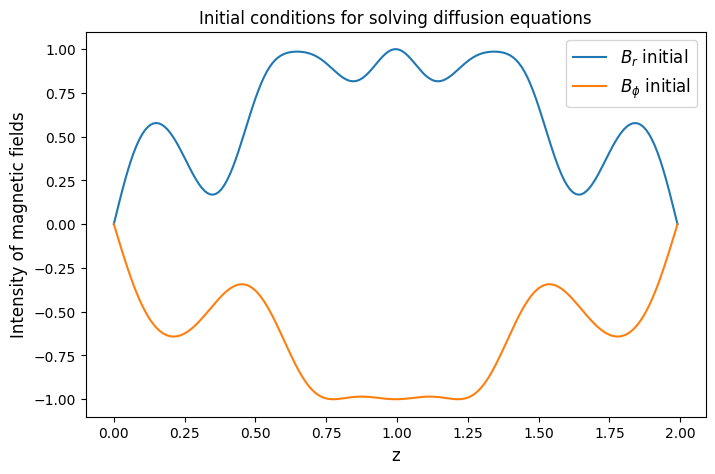

In [12]:
plt.figure(figsize=(8, 5))

plt.xlabel("Distance along z-axis", fontsize=12)
plt.ylabel("Intensity of magnetic fields", fontsize=12)

plt.plot(z, B_r, label=r"$B_r$ initial")
plt.plot(z, B_phi, label=r"$B_\phi$ initial")
plt.title("Initial conditions for solving diffusion equations")
plt.xlabel("z")
plt.legend(fontsize=12)
plt.savefig("IC_" + bc_type + "_" + str(ic_count) + ".jpg", dpi =600, bbox_inches='tight')
plt.show()

In [13]:
# Time-stepping scheme using Runge-Kutta
B_r_t = B_r
B_phi_t = B_phi

time_evol = [[],[]]

for time_step in dt:
    B_r_t, B_phi_t = rk4(B_r_t, B_phi_t, dt=time_step)
    
    # Vaccum Boundary Conditions
    B_r_t[0] = 0
    B_r_t[-1] = 0
    B_phi_t[0] = 0
    B_phi_t[-1] = 0

    time_evol[0].append(B_r_t)
    time_evol[1].append(B_phi_t)

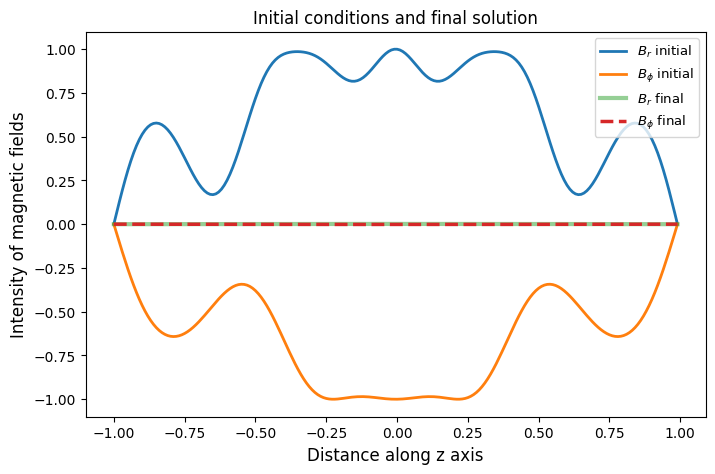

In [14]:
# Plotting results for running both B_r and B_phi results

plt.figure(figsize=(8, 5))

plt.xlabel("Distance along z axis", fontsize=12)
plt.ylabel("Intensity of magnetic fields", fontsize=12)
plt.title("Initial conditions and final solution")

plt.plot(z_0_ctr, B_r, linewidth=2, label=r"$B_r$ initial")
plt.plot(z_0_ctr, B_phi, linewidth=2, label=r"$B_\phi$ initial")
plt.plot(z_0_ctr, B_r_t, linewidth=3, alpha=0.5, label=r"$B_r$ final")
plt.plot(z_0_ctr, B_phi_t, "--", linewidth=2.5, label=r"$B_\phi$ final")

plt.legend(fontsize=9.5)
plt.savefig("IC_vs_FC_" + bc_type + "_" + str(ic_count) + ".jpg", dpi=600, bbox_inches='tight')
plt.show()

In [38]:
# define the true objective function
def objective(x, a, b, c):
    return a * np.exp(-b * x) + c

# we pick a value of z to check the decay rate of the magnetic field
z_value = 0.5

r_index = np.where(z==z_value)[0][0]
time = t[:-1]

Eqn for B_r = y = 0.69744 * exp(-1.35124 * t) + 0.00131


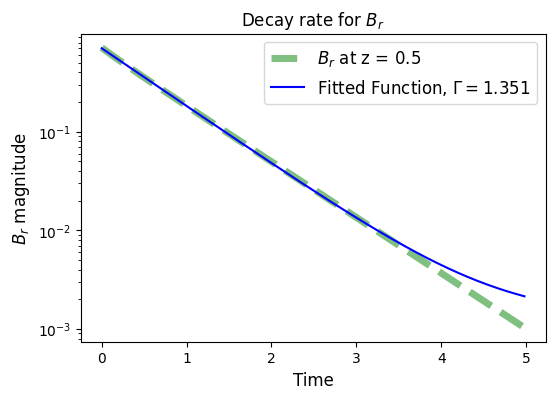

In [39]:
plt.figure(figsize=(6, 4))
plt.xlabel("Time", fontsize=12)
plt.ylabel(r"$B_r$" + " magnitude", fontsize=12)
plt.title(r"Decay rate for $B_r$", fontsize=12)

temp = []
for i in range(len(time_evol[0])):
    temp.append(time_evol[0][i][r_index])

# fitting the curve
popt, _ = curve_fit(objective, time, temp)

# list of parameter values
a, b, c = popt
x_line = np.arange(min(time), max(time), 0.01)
y_line = objective(x_line, a, b, c)

print("Eqn for B_r = " + 'y = %.5f * exp(-%.5f * t) + %.5f' % (a, b, c))

plt.plot(time, np.array(temp), "--", c='g', linewidth=5, alpha=0.5, label=r"$B_r$ at z = " + str(z_value))
# Fit 
plt.plot(x_line, y_line, color='b', label=r'Fitted Function, $\Gamma =$'+str(round(b, 3)))

plt.legend(fontsize=12)
plt.yscale('log')
plt.savefig("Br_Time_Evolution_" + bc_type + "_" + str(ic_count) + ".jpg", dpi =600, bbox_inches='tight')
plt.show()

-1.3041038735784096
-0.39031998048250527


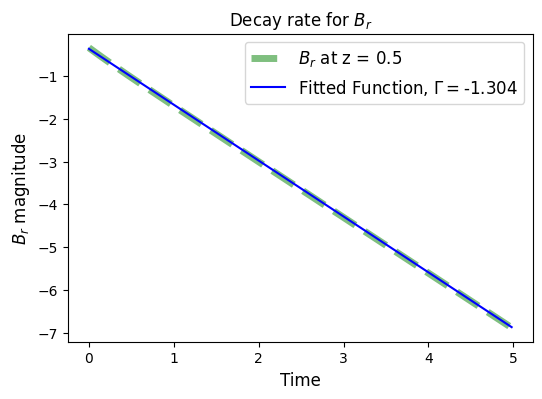

In [40]:
log_B_r = np.log(temp)

m, c = np.polyfit(time, log_B_r, 1)

print(m)
print(c)

x_line = np.arange(min(time), max(time), 0.01)
y_line = np.log(-(c-0.3)*2.7182818285**(m*time))

plt.figure(figsize=(6, 4))
plt.xlabel("Time", fontsize=12)
plt.ylabel(r"$B_r$" + " magnitude", fontsize=12)
plt.title(r"Decay rate for $B_r$", fontsize=12)

plt.plot(time, log_B_r, "--", c='g', linewidth=5, alpha=0.5, label=r"$B_r$ at z = " + str(z_value))
# Fit 
plt.plot(x_line, y_line, color='b', label=r'Fitted Function, $\Gamma =$'+str(round(m, 3)))

plt.legend(fontsize=12)
#plt.yscale('log')
plt.savefig("Br_Time_Evolution_" + bc_type + "_" + str(ic_count) + ".jpg", dpi =600, bbox_inches='tight')
plt.show()

Eqn for B_phi = y = -0.39416 * exp(-1.04835 * t) + 0.00392


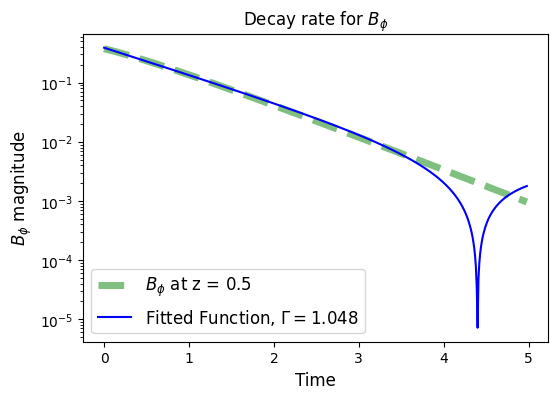

In [41]:
plt.figure(figsize=(6, 4))
plt.xlabel("Time", fontsize=12)
plt.ylabel(r"$B_\phi$" + " magnitude", fontsize=12)
plt.title(r"Decay rate for $B_\phi$", fontsize=12)

temp = []
for i in range(len(time_evol[1])):
    temp.append(time_evol[1][i][r_index])

# fitting the curve
popt, _ = curve_fit(objective, time, temp)
# list of parameter values
a, b, c = popt
x_line = np.arange(min(time), max(time), 0.01)
y_line = objective(x_line, a, b, c)

print("Eqn for B_phi = " + 'y = %.5f * exp(-%.5f * t) + %.5f' % (a, b, c))

plt.plot(time, np.abs(np.array(temp)), "--", c='g', linewidth=5, alpha=0.5, label=r"$B_\phi$ at z = " + str(z_value))
# Fit 
plt.plot(x_line, np.abs(y_line), color='b', label=r'Fitted Function, $\Gamma =$' + str(round(b, 3)))

plt.legend(fontsize=12)
plt.yscale('log')
plt.savefig("Bphi_Time_Evolution_"  + bc_type + "_" + str(ic_count) + ".jpg", dpi =600, bbox_inches='tight')
plt.show()

-1.2206844519996154
-0.796648188500981


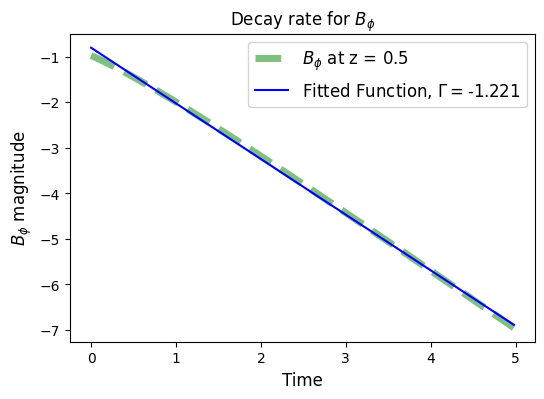

In [42]:
log_B_phi = np.log(np.abs(temp))

m, c = np.polyfit(time, log_B_phi, 1)

print(m)
print(c)

x_line = np.arange(min(time), max(time), 0.01)
y_line = np.log(-(c+0.35)*2.7182818285**(m*time))

plt.figure(figsize=(6, 4))
plt.xlabel("Time", fontsize=12)
plt.ylabel(r"$B_\phi$" + " magnitude", fontsize=12)
plt.title(r"Decay rate for $B_\phi$", fontsize=12)

plt.plot(time, log_B_phi, "--", c='g', linewidth=5, alpha=0.5, label=r"$B_\phi$ at z = " + str(z_value))
# Fit 
plt.plot(x_line, y_line, color='b', label=r'Fitted Function, $\Gamma =$'+str(round(m, 3)))

plt.legend(fontsize=12)
#plt.yscale('log')
plt.savefig("Bphi_Time_Evolution_" + bc_type + "_" + str(ic_count) + ".jpg", dpi =600, bbox_inches='tight')
plt.show()

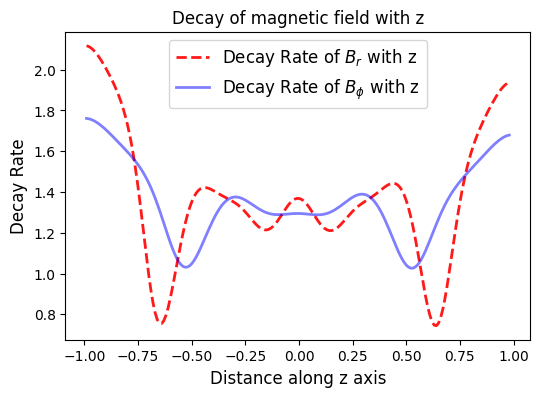

In [43]:
# decay rate of the magnetic field strength with r
plt.figure(figsize=(6, 4))
plt.title("Decay of magnetic field with z", fontsize=12)
plt.xlabel("Distance along z axis", fontsize=12)
plt.ylabel("Decay Rate", fontsize=12)

decay_rate = []
for r_value in z_0_ctr:
    r_index = np.where(z_0_ctr==r_value)[0][0]
    time = t[:-1]

    temp = []
    for i in range(len(time_evol[0])):
        temp.append(time_evol[0][i][r_index])

    # curve fit
    popt, _ = curve_fit(objective, time, temp)
    # summarize the parameter values
    a, b, c = popt

    decay_rate.append(b)

plt.plot(z_0_ctr[1:-1], decay_rate[1:-1], "--", c='r', linewidth=2, alpha=0.9, label=r"Decay Rate of $B_r$ with z" )

decay_rate = []
for r_value in z_0_ctr:
    r_index = np.where(z_0_ctr==r_value)[0][0]
    time = t[:-1]

    temp = []
    for i in range(len(time_evol[1])):
        temp.append(time_evol[1][i][r_index])

    # curve fit
    popt, _ = curve_fit(objective, time, temp)
    # summarize the parameter values
    a, b, c = popt

    decay_rate.append(b)
plt.plot(z_0_ctr[1:-1], decay_rate[1:-1], c='b', linewidth=2, alpha=0.5, label=r"Decay Rate of $B_\phi$ with z" )

plt.legend(fontsize=12)
plt.savefig("Decay_Rate_"  + bc_type + "_" + str(ic_count) + ".jpg", dpi =600, bbox_inches='tight')
plt.show()

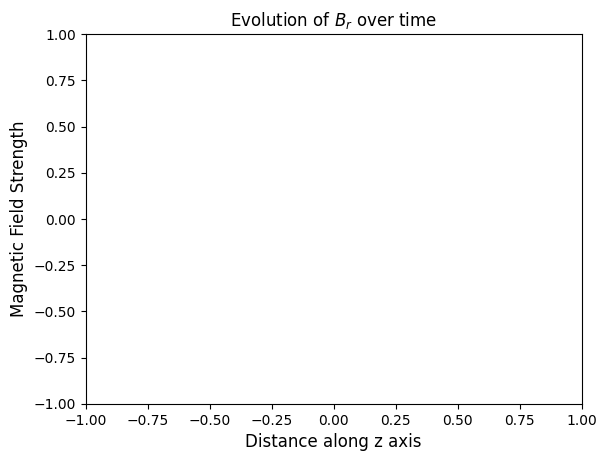

MovieWriter imagemagick unavailable; using Pillow instead.


In [83]:
# make an animation that visualizes the time evolution of the magnetic field
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
# background color
fig.patch.set_facecolor('white')


ax.set_xlabel("Distance along z axis", fontsize=12)
ax.set_ylabel("Magnetic Field Strength", fontsize=12)
ax.set_title(r"Evolution of $B_r$ over time", fontsize=12)

ax.set_xlim((z_min-1, z_max-1))
ax.set_ylim((-1, 1))
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)
def animate(i):
    x = z_0_ctr
    y = time_evol[0][i]
    line.set_data(x, y)
    return (line,)
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(time_evol[0]), interval=100, blit=True, repeat=True)
plt.show()

# removes the white space around the plot
fig.tight_layout()

ani.save('B_r_evolution_'  + bc_type + "_" + str(ic_count) + '.gif', writer='imagemagick', fps=10, dpi=300)

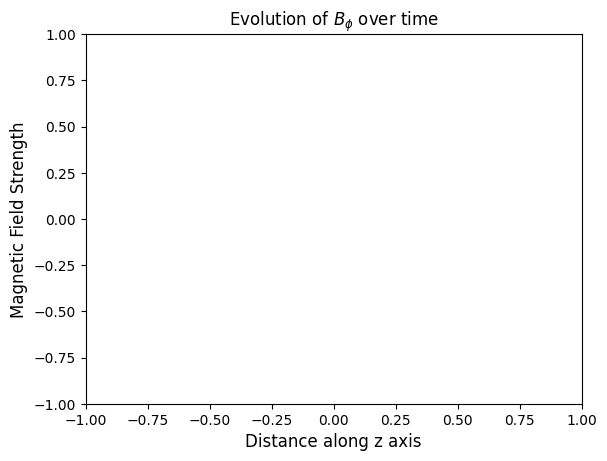

MovieWriter imagemagick unavailable; using Pillow instead.


In [84]:
# make an animation that visualizes the time evolution of the magnetic field

fig, ax = plt.subplots()
# background color
fig.patch.set_facecolor('white')

ax.set_xlabel("Distance along z axis", fontsize=12)
ax.set_ylabel("Magnetic Field Strength", fontsize=12)
ax.set_title(r"Evolution of $B_\phi$ over time", fontsize=12)

ax.set_xlim((z_min-1, z_max-1))
ax.set_ylim((-1, 1))
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)
def animate(i):
    x = z_0_ctr
    y = time_evol[1][i]
    line.set_data(x, y)
    return (line,)
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(time_evol[1]), interval=100, blit=True, repeat=True)
plt.show()

# removes the white space around the plot
fig.tight_layout()

ani.save('B_phi_evolution_' + bc_type + "_" + str(ic_count) + '.gif', writer='imagemagick', fps=10, dpi=300)

C:\Users\Ratul\AppData\Local\Temp\ipykernel_8924\2955747580.py:2: RuntimeWarning: invalid value encountered in divide
  return np.degrees(np.arctan(B_r/B_phi))


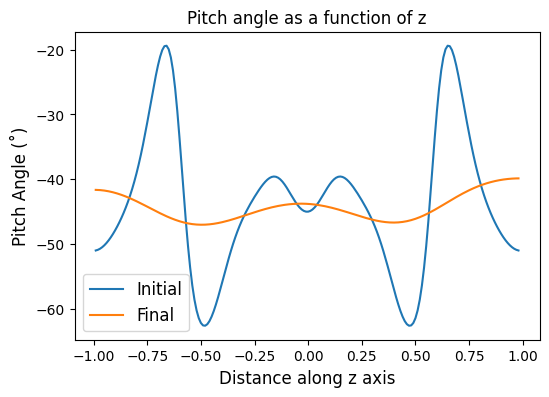

In [85]:
def pitch_angle(B_r, B_phi):
    return np.degrees(np.arctan(B_r/B_phi))

plt.figure(figsize=(6, 4))
plt.xlabel("Distance along z axis", fontsize=12)
plt.ylabel("Pitch Angle (˚)", fontsize=12)
plt.title(r"Pitch angle as a function of z", fontsize=12)

plt.plot(z_0_ctr[1:-1], pitch_angle(B_r, B_phi)[1:-1], label="Initial")
plt.plot(z_0_ctr[1:-1], pitch_angle(B_r_t, B_phi_t)[1:-1], label="Final")
plt.legend(fontsize=12)
plt.savefig("Pitch_Angle_"  + bc_type + "_" + str(ic_count) + ".jpg", dpi=600, bbox_inches='tight')
plt.show()